In [4]:
import gzip
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import random
from sklearn import linear_model
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import pandas as pd
from scipy.sparse import lil_matrix

In [5]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [7]:
data = []
count = 0
for d in readGz('data/ratebeer.json.gz'):
    count += 1
    data.append(d)
    d['review/overall'] = int(d['review/overall'].split('/')[0])
    if (count >= 80000):
        break
random.seed(30)
random.shuffle(data)

In [8]:
len(set([d['review/profileName'] for d in data]))

7005

In [9]:
data[0]

{'beer/name': 'Lagunitas Lumpy Gravy',
 'beer/beerId': '82243',
 'beer/brewerId': '1167',
 'beer/ABV': '7.2',
 'beer/style': 'American Strong Ale',
 'review/appearance': '3/5',
 'review/aroma': '7/10',
 'review/palate': '3/5',
 'review/taste': '6/10',
 'review/overall': 16,
 'review/time': '1200873600',
 'review/profileName': 'Naven',
 'review/text': '22 oz bottle.  Copper/Amber color. Nice hoppy aroma.  Flavor is mildly hoppy - more malty than im used to from Lagunitas.  Not their best, but pretty good.   Surprised by the  really low ratings.'}

## EDA

In [10]:
# Distribution of Overall Review
overallReviews = [d['review/overall'] for d in data]

In [11]:
review_series = pd.Series(overallReviews)
review_series.describe()

count    80000.000000
mean        13.661038
std          2.946579
min          1.000000
25%         12.000000
50%         14.000000
75%         16.000000
max         20.000000
dtype: float64

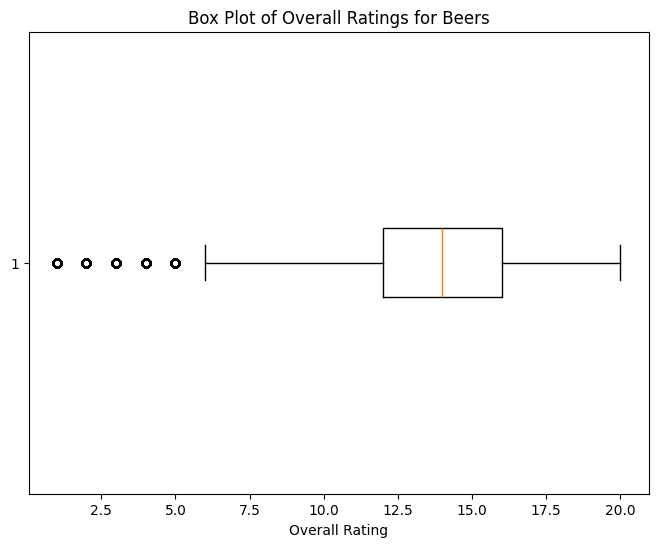

In [12]:
# Draw a box plot
plt.figure(figsize=(8, 6))
plt.boxplot(review_series, vert=False)
plt.title('Box Plot of Overall Ratings for Beers')
plt.xlabel('Overall Rating')
plt.show()

Text(0, 0.5, 'Proportion')

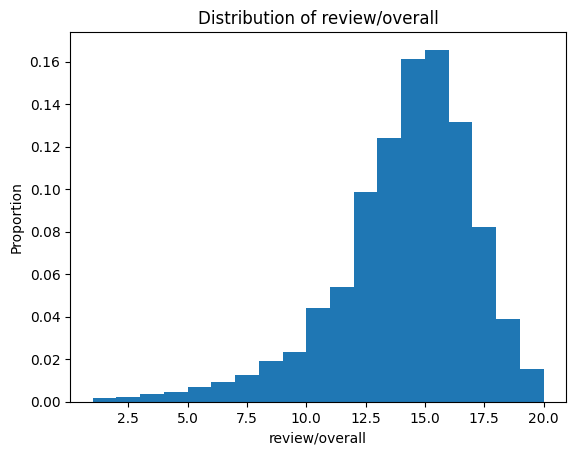

In [13]:
plt.hist(overallReviews, bins=19, density=True)
plt.title('Distribution of review/overall')
plt.xlabel('review/overall')
plt.ylabel('Proportion')

In [14]:
ABVs = [d['beer/ABV'] for d in data if d['beer/ABV'][0].isnumeric()]

In [15]:
abvdict = {}
for d in data:
    if d['beer/ABV'][0].isnumeric():
        firstDigit = d['beer/ABV'][0]
    if firstDigit in abvdict.keys():
        abvdict[firstDigit].append(d['review/overall'])
    else:
        abvdict[firstDigit] = [d['review/overall']]

In [18]:
avgReviewPerABV = {key: np.average(value) for key, value in abvdict.items()}
ABVkeys = list(avgReviewPerABV.keys())
ABVkeys.sort()
sortedABVDict = {'[' + i + ',' + str(int(i) + 1) + ')': avgReviewPerABV[i] for i in ABVkeys}
sortedABVDict

{'[0,1)': 6.4324324324324325,
 '[1,2)': 14.717828418230564,
 '[2,3)': 11.049079754601227,
 '[3,4)': 11.42992700729927,
 '[4,5)': 11.632089016511127,
 '[5,6)': 12.465455076983044,
 '[6,7)': 13.656066274719402,
 '[7,8)': 14.549052299052299,
 '[8,9)': 14.859623484913607,
 '[9,10)': 15.21725417439703}

Text(0, 0.5, 'Average review/overall')

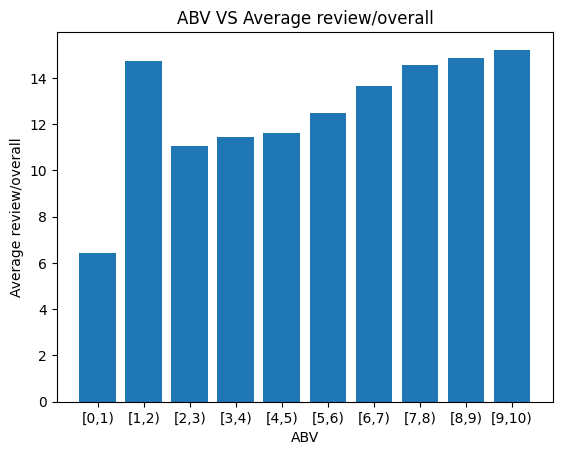

In [19]:
plt.bar(sortedABVDict.keys(), sortedABVDict.values())
plt.title('ABV VS Average review/overall')
plt.xlabel('ABV')
plt.ylabel('Average review/overall')

In [20]:
[d['beer/style'] for d in data][:10]

['American Strong Ale',
 'American Strong Ale',
 'Abbey Dubbel',
 'Belgian White &#40;Witbier&#41;',
 'Stout',
 'Imperial/Double IPA',
 'Golden Ale/Blond Ale',
 'Wheat Ale',
 'Abbey Dubbel',
 'American Strong Ale']

## Baseline Model

In [21]:
trainSet = data[:60000]
validSet = data[60000:70000]
testSet = data[70000:]

In [22]:
def MSE(y, ypred):
    differences = [(a-b)**2 for a,b in zip(y,ypred)]
    return sum(differences) / len(differences)

In [23]:
allRatings = [d['review/overall'] for d in data]
avgRating = np.average(allRatings)
avgRating

13.6610375

In [24]:
basePred = [avgRating] * len(validSet)
validRating = [d['review/overall'] for d in validSet]
validMSE1 = MSE(validRating, basePred)
validMSE1

8.614355843906086

In [25]:
testRating = [d['review/overall'] for d in testSet]
testMSE1 = MSE(testRating, basePred)
testMSE1

8.546889263906062

## Jaccard Similarity Model

#### Originial Jaccard

In [30]:
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
ratingDict = {}
reviewsPerUser = defaultdict(list)

for d in trainSet:
    user,item = d['review/profileName'], d['beer/beerId']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    reviewsPerUser[user].append(d)

for d in data:
    user,item = d['review/profileName'], d['beer/beerId']
    ratingDict[(user,item)] = d['review/overall']

In [32]:
userAverages = {}
itemAverages = {}

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)

ratingMean = sum([d['review/overall'] for d in trainSet]) / len(trainSet)

In [41]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [42]:
def predByJaccard(user,item):
    if item not in usersPerItem.keys():
        return ratingMean
    
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['beer/beerId']
        if i2 == item: continue
        ratings.append(d['review/overall'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x * y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        return itemAverages[item]

In [43]:
predByJaccardValid = [predByJaccard(d['review/profileName'], d['beer/beerId']) for d in validSet]
validMSE2 = MSE(validRating, predByJaccardValid)
validMSE2

4.438546298346655

In [45]:
predByJaccardTest = [predByJaccard(d['review/profileName'], d['beer/beerId']) for d in testSet]
testMSE2 = MSE(testRating, predByJaccardTest)
testMSE2

4.5205054538600375

#### Improved Jaccard

In [67]:
maxReviewLength = np.mean(([len(d['review/text']) for d in data]))

In [84]:
maxReviewLength = max([len(d['review/text']) for d in data])
maxReviewLength

6450

In [98]:
reviewPercentilePerItem = {}
for d in trainSet:
    reviewPercentilePerItem[d['beer/beerId']] = 3.5 ** (len(d['review/text']) / maxReviewLength)

In [99]:
def predByImprovedJaccard(user, item):
    if item not in usersPerItem.keys():
        return ratingMean
    
    ratings = []
    similarities = []
    reviewPercentiles = []
    for d in reviewsPerUser[user]:
        i2 = d['beer/beerId']
        if i2 == item: continue
        ratings.append(d['review/overall'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item], usersPerItem[i2]))
        reviewPercentiles.append(reviewPercentilePerItem[i2])
    if (sum(similarities) > 0):
        weightedRatings = [(x * y * z) for x, y, z in zip(ratings, similarities, reviewPercentiles)]
        weighting = [(x * y) for x, y in zip(similarities, reviewPercentiles)]
        return itemAverages[item] + sum(weightedRatings) / sum(weighting)
    else:
        return itemAverages[item]


In [101]:
predByImprovedJaccardValid = [predByImprovedJaccard(d['review/profileName'], d['beer/beerId']) for d in validSet]
validMSE3 = MSE(validRating, predByImprovedJaccardValid)
validMSE3

4.436091754537068

In [100]:
predByImprovedJaccardTest = [predByImprovedJaccard(d['review/profileName'], d['beer/beerId']) for d in testSet]
testMSE3 = MSE(testRating, predByImprovedJaccardTest)
testMSE3

4.521760911570164

# Bag-of-Word Model

In [ ]:
sp = set(string.punctuation)

In [ ]:
# how many unique words are there?
wordCount = defaultdict(int)
for d in data:
    for w in d['review/text'].split():
        wordCount[w] += 1

len(wordCount)


141941

In [ ]:
# Ignore capitalization and remove punctuation
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data:
    r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

len(wordCount)

77028

In [ ]:
# With stemming
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
for d in data:
  r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
  for w in r.split():
    w = stemmer.stem(w)
    wordCount[w] += 1
    
len(wordCount)


64153

In [ ]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [ ]:
# top 10 word frequency removing punctuation 
counts[:10]

[(187221, 'a'),
 (152103, 'and'),
 (130576, 'the'),
 (114149, 'with'),
 (98452, 'of'),
 (80438, 'is'),
 (56759, 'head'),
 (53003, 'aroma'),
 (43742, 'sweet'),
 (43695, 'it')]

In [ ]:
words = [x[1] for x in counts[:1000]]

## Sentiment analysis

In [ ]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [ ]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

trainSet = data[:60000]
validSet = data[60000:70000]
testSet = data[70000:]

In [ ]:
train_X = [feature(d) for d in trainSet]
train_y = [d['review/overall'] for d in trainSet]

clf.fit(train_X, train_y)

Ridge(fit_intercept=False)

In [ ]:
valid_X = [feature(d) for d in validSet]
valid_y = [d['review/overall'] for d in validSet]

alphas = [0.0001, 0.0005, 0.001, 0.005]
best_alpha = None
best_score = float('-inf')

for alpha in alphas:
    clf = linear_model.Ridge(alpha, fit_intercept=False)
    clf.fit(train_X, train_y)
    valid_predictions = clf.predict(valid_X)
    score = mean_squared_error(valid_y, valid_predictions)

    if score > best_score:
        best_score = score
        best_alpha = alpha

print("Best Alpha:", best_alpha)


Best Alpha: 0.0001


In [ ]:
test_X = [feature(d) for d in testSet]
test_y = [d['review/overall'] for d in testSet]

# Train the final model with the best alpha
final_clf = linear_model.Ridge(best_alpha, fit_intercept=False)
final_clf.fit(train_X, train_y)

# Evaluate on training set
train_predictions = final_clf.predict(train_X)
train_accuracy = mean_squared_error(train_y, train_predictions)

# Evaluate on validation set (using the best_alpha)
valid_predictions = final_clf.predict(valid_X)
valid_accuracy = mean_squared_error(valid_y, valid_predictions)

# Evaluate on testing set (using the best_alpha)
test_predictions = final_clf.predict(test_X)
test_accuracy = mean_squared_error(test_y, test_predictions)

print("Training MSE:", train_accuracy)
print("Validation MSE:", valid_accuracy)
print("Testing MSE:", test_accuracy)


Training MSE: 5.87862520817977
Validation MSE: 5.711526746785274
Testing MSE: 5.885832707918955


In [ ]:
def feature(datum, words, wordId, tolower=True, removePunct=True):
    feat = [0]*len(words)
    r = datum['review/text']
    if tolower:
        r = r.lower()
    if removePunct:
        r = ''.join([c for c in r if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [ ]:
def pipeline(dSize = 1000, tolower=True, removePunct=True, removeStem=True):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in data: # Strictly, should just use the *training* data to extract word counts
        r = d['review/text']
        if tolower:
            r = r.lower()
        if removePunct:
            r = ''.join([c for c in r if not c in punctuation])
        for w in r.split():
            if removeStem:
                w = stemmer.stem(w)
            wordCount[w] += 1

    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()
    
    words = [x[1] for x in counts[:dSize]]
    
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)
    
    nf = len(feature(data[0], words, wordId, tolower, removePunct))

    #Sparse matrix
    X = lil_matrix((len(data), nf))

    for i in range(len(data)):
        x = feature(data[i], words, wordId, tolower, removePunct)
        for j in range(nf):
            if x[j]:
                X[i,j] = x[j]
    # X = [feature(d, words, wordId, tolower, removePunct) for d in data]
    y = [d['review/overall'] for d in data]
    
    Ntrain,Nvalid,Ntest = 60000,10000,10000
    Xtrain,Xvalid,Xtest = X[:Ntrain],X[Ntrain:Ntrain+Nvalid],X[Ntrain+Nvalid:]
    ytrain,yvalid,ytest = y[:Ntrain],y[Ntrain:Ntrain+Nvalid],y[Ntrain+Nvalid:]
    
    bestModel = None
    bestVal = None
    bestLamb = None
    
    ls = [0.01, 0.1, 1, 10, 100, 1000, 10000]
    errorTrain = []
    errorValid = []

    for l in ls:
        model = linear_model.Ridge(l)
        model.fit(Xtrain, ytrain)
        predictTrain = model.predict(Xtrain)
        MSEtrain = sum((ytrain - predictTrain)**2)/len(ytrain)
        errorTrain.append(MSEtrain)
        predictValid = model.predict(Xvalid)
        MSEvalid = sum((yvalid - predictValid)**2)/len(yvalid)
        errorValid.append(MSEvalid)
        print("l = " + str(l) + ", validation MSE = " + str(MSEvalid))
        if bestVal == None or MSEvalid < bestVal:
            bestVal = MSEvalid
            bestModel = model
            bestLamb = l
       
    # predictTest = bestModel.predict(Xtest)
    # MSEtest = sum((ytest - predictTest)**2)/len(ytest)
    print("best lambda = " + str(bestLamb))
    print("Valid MSE = " + str(bestVal)) 
    
    # plt.xticks([])
    # plt.xlabel(r"$\lambda$")
    # plt.ylabel(r"error (MSE)")
    # plt.title(r"Validation Pipeline")
    # plt.xscale('log')
    # plt.plot(ls, errorTrain, color='k', linestyle='--', label='training error')
    # plt.plot(ls, errorValid, color='grey',zorder=4,label="validation error")
    # plt.plot([bestLamb], [MSEtest], linestyle='', marker='x', color='k', label="test error")
    # plt.legend(loc='best')
    # plt.show()

    return bestVal

l = 0.01, validation MSE = 5.321770873617987
l = 0.1, validation MSE = 5.321899242964116
l = 1, validation MSE = 5.320322516337781
l = 10, validation MSE = 5.308438043178138
l = 100, validation MSE = 5.285465933572803
l = 1000, validation MSE = 5.65896086555177
l = 10000, validation MSE = 6.785938966907171
best lambda = 100
Testing MSE = 5.5064450560258535


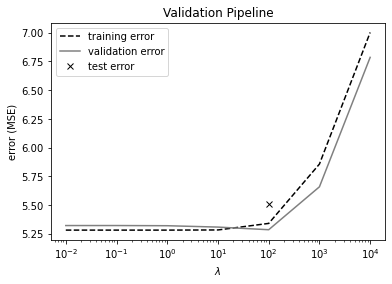

In [ ]:
pipeline(2000, False, False, False)

l = 0.01, validation MSE = 5.7078369703269205
l = 0.1, validation MSE = 5.707758860765356
l = 1, validation MSE = 5.70549504265747
l = 10, validation MSE = 5.69738728425474
l = 100, validation MSE = 5.683809996543534
l = 1000, validation MSE = 5.833741559810215
l = 10000, validation MSE = 6.60659380289235
best lambda = 100
Testing MSE = 5.858231051318223


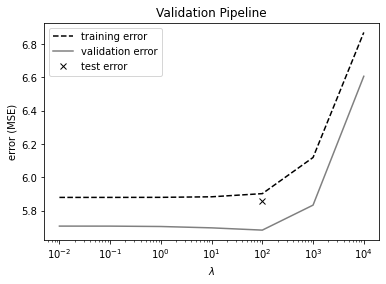

In [ ]:
pipeline(1000, True, True, True)

In [ ]:
# Create a DataFrame to record the results
results_df = pd.DataFrame(columns=['tolower', 'removePunct', 'removeStem', 'valid_MSE'])

# Iterate over all combinations of pipeline parameters
for tolower in [True, False]:
    for removePunct in [True, False]:
        for removeStem in [True, False]:
            validMSE = pipeline(1000, tolower, removePunct, removeStem)
            # Record the results
            result_row = {'tolower': tolower, 'removePunct': removePunct, 'removeStem': removeStem}
            result_row['valid_MSE'] = validMSE
            results_df = results_df.append(result_row, ignore_index=True)


l = 0.01, validation MSE = 5.7078369703269205
l = 0.1, validation MSE = 5.707758860765356
l = 1, validation MSE = 5.70549504265747
l = 10, validation MSE = 5.69738728425474
l = 100, validation MSE = 5.683809996543534
l = 1000, validation MSE = 5.833741559810215
l = 10000, validation MSE = 6.60659380289235
best lambda = 100
Valid MSE = 5.683809996543534
l = 0.01, validation MSE = 5.2068689065355285
l = 0.1, validation MSE = 5.206970171754229
l = 1, validation MSE = 5.2064881812232855
l = 10, validation MSE = 5.203334434910269
l = 100, validation MSE = 5.189600604942346
l = 1000, validation MSE = 5.339723026765927
l = 10000, validation MSE = 6.242819017351219
best lambda = 100
Valid MSE = 5.189600604942346
l = 0.01, validation MSE = 5.803694761840145
l = 0.1, validation MSE = 5.803635573160736
l = 1, validation MSE = 5.800910841478318
l = 10, validation MSE = 5.8021301819046585
l = 100, validation MSE = 5.802359071756375
l = 1000, validation MSE = 6.0066413555734
l = 10000, validation MS

In [ ]:
results_df

,tolower,removePunct,removeStem,valid_MSE
0,True,True,True,5.683810
1,True,True,False,5.189601
2,True,False,True,5.800911
3,True,False,False,5.477513
4,False,True,True,6.071314
5,False,True,False,5.383918
6,False,False,True,6.173742
7,False,False,False,5.673993


In [ ]:
def pipelineTesting(dSize = 1000, best_lambda = 100, tolower=True, removePunct=True, removeStem=True):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in data: # Strictly, should just use the *training* data to extract word counts
        r = d['review/text']
        if tolower:
            r = r.lower()
        if removePunct:
            r = ''.join([c for c in r if not c in punctuation])
        for w in r.split():
            if removeStem:
                w = stemmer.stem(w)
            wordCount[w] += 1

    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()
    
    words = [x[1] for x in counts[:dSize]]
    
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)
    
    nf = len(feature(data[0], words, wordId, tolower, removePunct))

    #Sparse matrix
    X = lil_matrix((len(data), nf))

    for i in range(len(data)):
        x = feature(data[i], words, wordId, tolower, removePunct)
        for j in range(nf):
            if x[j]:
                X[i,j] = x[j]
    # X = [feature(d, words, wordId, tolower, removePunct) for d in data]
    y = [d['review/overall'] for d in data]
    
    Ntrain,Nvalid,Ntest = 60000,10000,10000
    Xtrain,Xvalid,Xtest = X[:Ntrain],X[Ntrain:Ntrain+Nvalid],X[Ntrain+Nvalid:]
    ytrain,yvalid,ytest = y[:Ntrain],y[Ntrain:Ntrain+Nvalid],y[Ntrain+Nvalid:]

    model = linear_model.Ridge(best_lambda)
    model.fit(Xtrain, ytrain)
       
    predictTest = model.predict(Xtest)
    MSEtest = sum((ytest - predictTest)**2)/len(ytest)
    
    print("best lambda = " + str(best_lambda))
    print("Testing MSE = " + str(MSEtest)) 
    
    # plt.xticks([])
    # plt.xlabel(r"$\lambda$")
    # plt.ylabel(r"error (MSE)")
    # plt.title(r"Validation Pipeline")
    # plt.xscale('log')
    # plt.plot(ls, errorTrain, color='k', linestyle='--', label='training error')
    # plt.plot(ls, errorValid, color='grey',zorder=4,label="validation error")
    # plt.plot([bestLamb], [MSEtest], linestyle='', marker='x', color='k', label="test error")
    # plt.legend(loc='best')
    # plt.show()

    return MSEtest

In [ ]:
pipelineTesting(1000, 100, True, True, False)

best lambda = 100
Testing MSE = 5.339593169244341


5.339593169244341